In [21]:
import os, math
from PIL import Image, ImageDraw, ImageFont
from tensorflow.keras.datasets import cifar10, mnist
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization 
from tensorflow.keras.layers import Conv2D, Flatten, Activation
from tensorflow.keras.layers import Reshape, Conv2DTranspose, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import mse, SparseCategoricalCrossentropy

In [2]:
(x_train, y_train),(x_test, _) = mnist.load_data()


11493376/11490434 [==============================] - 0s 0us/step


In [76]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train / 255

In [78]:
x_train.max()

1.0

In [ ]:
image_size = x_train[0].shape[1]
image_size

In [5]:
class ConvTransBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides):
        super().__init__()
        self.bn = BatchNormalization()  # check training flag
        self.act = Activation(activation='relu')
        self.conv2D_trans = Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=strides,
                                padding='same')
        
    def call(self, inputs, training=False):
        x = self.bn(inputs)
        x = self.act(x)
        return self.conv2D_trans(x)


In [6]:
noise = np.random.uniform(0, 1, size=[10000, 100])


In [7]:
# model = Sequential()
# model.add(Input(noise.shape[1]))
# model.add(Dense(14*14*32, activation="relu"))
# model.add(Reshape([14, 14, 32]))
# model.add(ConvTransBlock(32, 5, 2))
# model.add(ConvTransBlock(16, 5, 1))
# model.add(Conv2DTranspose(1, 5, padding="same", activation="sigmoid"))


In [ ]:
# model.compile(loss="MSE", metrics=["MAE"])
# model.fit(noise, x_train.reshape(-1, 28, 28, 1)[:10000])

In [8]:
class Generator(tf.keras.models.Model):
    def __init__(self, filters, kernel_size, resize_img):
        super().__init__()
        self.dense1 = Dense(resize_img * resize_img * filters[0])
        self.reshape = Reshape([resize_img, resize_img, filters[0]])
        self.conv2dtrans = []
        for i, _filter in enumerate(filters):
            if i <= 1:
                strides = 2
            else:
                strides = 1
            self.conv2dtrans.append(ConvTransBlock(_filter, kernel_size, strides))
        
        self.act = Activation("sigmoid")

    def call(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.reshape(x)
        for conv in self.conv2dtrans:
            x = conv(x)
        return self.act(x)




In [ ]:
# gen = Generator(gen_layers_filter, gen_kernel_size, gen_resize_img)

NameError: ignored

In [ ]:
# gen.compile(loss="mse", metrics=["mae"])

In [ ]:
# gen.fit(noise, x_train.reshape(-1, 28, 28, 1)[:10000], batch_size=64)

In [9]:
def leaky_conv(filters, kernel_size, strides):
    return Sequential([LeakyReLU(alpha=0.2),
                       Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       padding='same')])


In [ ]:
# model = Sequential()
# model.add(Input(x_train.shape[1:]))
# model.add(leaky_conv(32, 5, 2))
# model.add(leaky_conv(64, 5, 2))
# model.add(Flatten())
# model.add(Dense(10))
# model.add(Activation("softmax"))

In [ ]:
# model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), metrics=["accuracy"])
# model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_10 (Sequential)   (None, 14, 14, 32)        832       
_________________________________________________________________
sequential_11 (Sequential)   (None, 7, 7, 64)          51264     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                31370     
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 83,466
Trainable params: 83,466
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# model.fit(x_train, y_train)

In [10]:
class Discriminator(tf.keras.models.Model):
    def __init__(self, filters, kernel_size):
        super().__init__()
        self.leaky_convs = []
        for i, _filter in enumerate(filters):
            if i < len(filters) - 1:
                strides = 2
            else:
                strides = 1
            self.leaky_convs.append(leaky_conv(_filter, kernel_size, strides))
        self.flat = Flatten()
        self.dense = Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = inputs
        for conv in self.leaky_convs:
            x = conv(x)
        x = self.flat(x)
        return self.dense(x)

In [ ]:
# disc = Discriminator(disc_layers_filters, disc_kernel_size)

In [ ]:
# disc.compile(loss="categorical_crossentropy", metrics=["mae"])

In [ ]:
# disc.fit(x_train, np.where(y_train < 5, 1, 0))

In [ ]:
# disc.summary()

Model: "discriminator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_12 (Sequential)   (32, 14, 14, 32)          832       
_________________________________________________________________
sequential_13 (Sequential)   (32, 7, 7, 64)            51264     
_________________________________________________________________
sequential_14 (Sequential)   (32, 4, 4, 128)           204928    
_________________________________________________________________
sequential_15 (Sequential)   (32, 4, 4, 256)           819456    
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  4097      
Total params: 1,080,577
Trainable params: 1,080,577
Non-trainable params: 0
_________________________________________

In [79]:
latent_size = 100
batch_size = 64
train_steps = 40000
disc_lr = 2e-4
disc_decay = 6e-8
gen_lr = disc_lr/2
gen_decay = disc_decay/2

disc_lr, disc_decay, gen_lr, gen_decay

(0.0002, 6e-08, 0.0001, 3e-08)

In [80]:
disc_kernel_size = 5
disc_layers_filters = [32, 64, 128, 256]

In [81]:
gen_resize_img = image_size // 4
gen_kernel_size = 5
gen_layers_filter = [128, 64, 32, 1]

In [82]:
gen = Generator(gen_layers_filter, gen_kernel_size, gen_resize_img)

In [83]:
disc = Discriminator(disc_layers_filters, disc_kernel_size)
disc.compile(loss='binary_crossentropy',
             optimizer=RMSprop(learning_rate=disc_lr, decay=disc_decay),
             metrics=['accuracy'])


In [84]:
def build_gan():
    # disc.trainable = False
    gan = Sequential(name='gan_model')
    gan.add(Input([100,]))
    gan.add(gen)
    gan.add(disc)
    gan.summary()
    gan.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=gen_lr, decay=gen_decay),
                metrics=['accuracy'])            
    return gan   


gan = build_gan()


Model: "gan_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_5 (Generator)      (None, 28, 28, 1)         1301505   
_________________________________________________________________
discriminator_5 (Discriminat (None, 1)                 1080577   
Total params: 2,382,082
Trainable params: 2,381,378
Non-trainable params: 704
_________________________________________________________________


In [85]:
for layer in gan.layers:
    print(layer.trainable)

True
True


In [86]:
def plot_images(generator,
                noise_input,
                noise_label=None,
                noise_codes=None,
                show=False,
                step=0,
                model_name="gan"):
    """Generate fake images and plot them

    For visualization purposes, generate fake images
    then plot them in a square grid

    # Arguments
        generator (Model): The Generator Model for 
            fake images generation
        noise_input (ndarray): Array of z-vectors
        show (bool): Whether to show plot or not
        step (int): Appended to filename of the save images
        model_name (string): Model name

    """
    # os.makedirs(model_name, exist_ok=True)
    # filename = os.path.join(model_name, "%05d.png" % step)
    rows = int(math.sqrt(noise_input.shape[0]))
    if noise_label is not None:
        noise_input = [noise_input, noise_label]
        if noise_codes is not None:
            noise_input += noise_codes

    images = generator.predict(noise_input)
    plt.figure(figsize=(10, 10))
    num_images = images.shape[0]
    image_size = images.shape[1]
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    # plt.savefig(filename)
    if show:
        
        plt.show()
    else:
        plt.close('all')

In [87]:
# Train the Discriminator and Adversarial Networks
def train(models, x_train):
    generator, discriminator, gan = models 
    # batch_size, latent_size, train_step, model_name = params
    save_interval = 500
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size]) 
    train_size = x_train.shape[0]

    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        fake_images = generator.predict(noise)        
        x = np.concatenate((real_images, fake_images)) # same size
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0
        # experimental
        y[: batch_size] = 0.9
        discriminator.trainable = True
        loss, acc = discriminator.train_on_batch(x, y)
        # log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
        log = f'{i}: [discriminator loss: {loss}, acc: {acc}]'
        discriminator.trainable = False

        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
        y = np.ones([batch_size, 1])        
        loss, acc = gan.train_on_batch(noise, y)
        log = "%s [gan loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            # plot generator images on a periodic basis
            plot_images(generator,
                        noise_input=noise_input,
                        show=True,
                        step=(i + 1),
                        model_name='gan_model')
    
        

0: [discriminator loss: 0.6997567415237427, acc: 0.0] [gan loss: 0.987655, acc: 0.000000]
1: [discriminator loss: 0.6570408940315247, acc: 0.5] [gan loss: 0.911752, acc: 0.000000]
2: [discriminator loss: 0.6047424077987671, acc: 0.5] [gan loss: 0.809514, acc: 0.000000]
3: [discriminator loss: 0.5252009034156799, acc: 0.5] [gan loss: 0.539394, acc: 1.000000]
4: [discriminator loss: 0.41239386796951294, acc: 0.5] [gan loss: 0.114349, acc: 1.000000]
5: [discriminator loss: 0.29888567328453064, acc: 0.5] [gan loss: 0.034962, acc: 1.000000]
6: [discriminator loss: 0.2233809530735016, acc: 0.5] [gan loss: 0.000591, acc: 1.000000]
7: [discriminator loss: 0.287579208612442, acc: 0.5] [gan loss: 0.133725, acc: 1.000000]
8: [discriminator loss: 0.25668153166770935, acc: 0.5] [gan loss: 0.000573, acc: 1.000000]
9: [discriminator loss: 0.18306869268417358, acc: 0.5] [gan loss: 0.000804, acc: 1.000000]
10: [discriminator loss: 0.17841333150863647, acc: 0.5] [gan loss: 0.000481, acc: 1.000000]
11: [

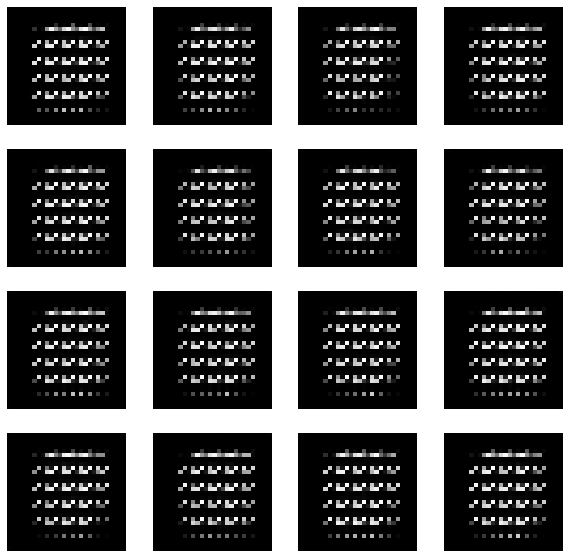

500: [discriminator loss: 0.34555554389953613, acc: 0.5] [gan loss: 2.512326, acc: 0.000000]
501: [discriminator loss: 0.3207136392593384, acc: 0.5] [gan loss: 1.352039, acc: 0.000000]
502: [discriminator loss: 0.33812612295150757, acc: 0.5] [gan loss: 2.369819, acc: 0.000000]
503: [discriminator loss: 0.2564980387687683, acc: 0.5] [gan loss: 1.275039, acc: 0.000000]
504: [discriminator loss: 0.28584718704223633, acc: 0.5] [gan loss: 1.690533, acc: 0.000000]
505: [discriminator loss: 0.2709035575389862, acc: 0.5] [gan loss: 1.184524, acc: 0.000000]
506: [discriminator loss: 0.2860843539237976, acc: 0.5] [gan loss: 1.461654, acc: 0.000000]
507: [discriminator loss: 0.256675124168396, acc: 0.5] [gan loss: 0.646904, acc: 0.718750]
508: [discriminator loss: 0.2898266911506653, acc: 0.5] [gan loss: 1.431739, acc: 0.000000]
509: [discriminator loss: 0.25048232078552246, acc: 0.5] [gan loss: 0.349962, acc: 1.000000]
510: [discriminator loss: 0.27312129735946655, acc: 0.5] [gan loss: 1.190628,

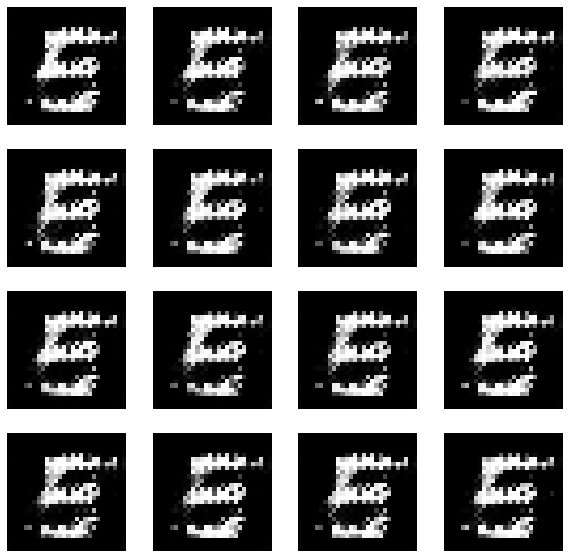

1000: [discriminator loss: 0.38471829891204834, acc: 0.5] [gan loss: 1.700691, acc: 0.000000]
1001: [discriminator loss: 0.5015870332717896, acc: 0.4296875] [gan loss: 2.809357, acc: 0.000000]
1002: [discriminator loss: 0.38074636459350586, acc: 0.5] [gan loss: 1.701766, acc: 0.000000]
1003: [discriminator loss: 0.5297238826751709, acc: 0.34375] [gan loss: 3.364573, acc: 0.000000]
1004: [discriminator loss: 0.356853723526001, acc: 0.5] [gan loss: 1.643357, acc: 0.000000]
1005: [discriminator loss: 0.49353164434432983, acc: 0.4296875] [gan loss: 2.782710, acc: 0.000000]
1006: [discriminator loss: 0.38112345337867737, acc: 0.5] [gan loss: 1.968254, acc: 0.000000]
1007: [discriminator loss: 0.5246958136558533, acc: 0.4140625] [gan loss: 2.547112, acc: 0.000000]
1008: [discriminator loss: 0.48254483938217163, acc: 0.4921875] [gan loss: 1.998748, acc: 0.000000]
1009: [discriminator loss: 0.47612494230270386, acc: 0.453125] [gan loss: 2.753142, acc: 0.000000]
1010: [discriminator loss: 0.463

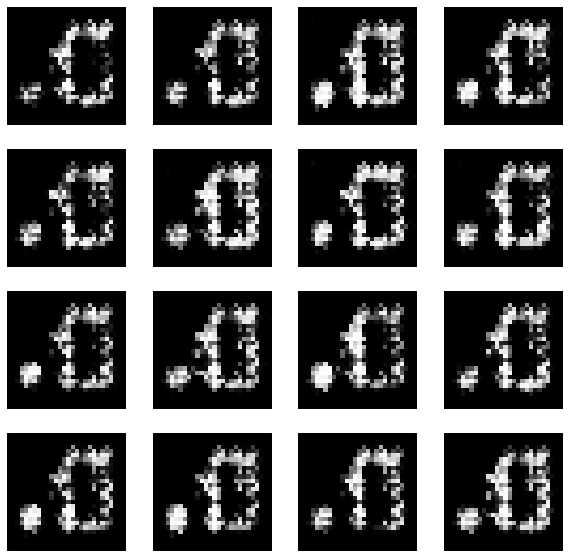

1500: [discriminator loss: 0.2607521414756775, acc: 0.5] [gan loss: 2.047242, acc: 0.000000]
1501: [discriminator loss: 0.3087010979652405, acc: 0.5] [gan loss: 2.321105, acc: 0.000000]
1502: [discriminator loss: 0.24663907289505005, acc: 0.5] [gan loss: 1.653837, acc: 0.000000]
1503: [discriminator loss: 0.3257228136062622, acc: 0.5] [gan loss: 2.710145, acc: 0.000000]
1504: [discriminator loss: 0.27956274151802063, acc: 0.5] [gan loss: 1.899410, acc: 0.000000]
1505: [discriminator loss: 0.3562100827693939, acc: 0.5] [gan loss: 3.254152, acc: 0.000000]
1506: [discriminator loss: 0.2907017767429352, acc: 0.5] [gan loss: 2.490891, acc: 0.000000]
1507: [discriminator loss: 0.38935935497283936, acc: 0.5] [gan loss: 3.062200, acc: 0.000000]
1508: [discriminator loss: 0.35113102197647095, acc: 0.5] [gan loss: 2.776018, acc: 0.000000]
1509: [discriminator loss: 0.3496338129043579, acc: 0.5] [gan loss: 2.201623, acc: 0.000000]
1510: [discriminator loss: 0.3789750039577484, acc: 0.5] [gan loss

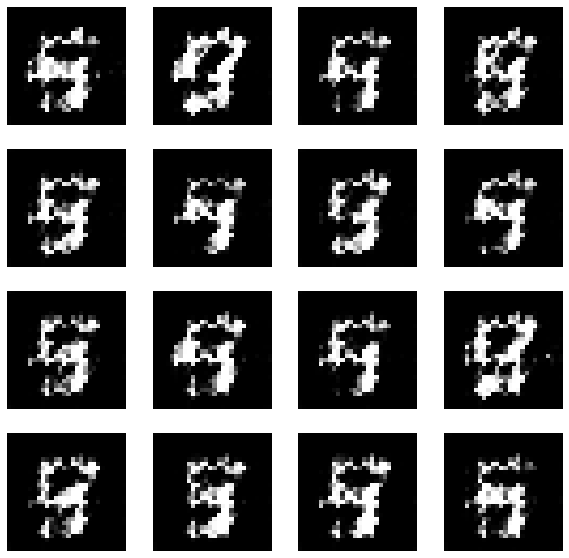

2000: [discriminator loss: 0.5664644837379456, acc: 0.3828125] [gan loss: 1.704592, acc: 0.000000]
2001: [discriminator loss: 0.6326727867126465, acc: 0.359375] [gan loss: 1.554629, acc: 0.000000]
2002: [discriminator loss: 0.5992388725280762, acc: 0.3671875] [gan loss: 1.630115, acc: 0.000000]
2003: [discriminator loss: 0.5141295194625854, acc: 0.453125] [gan loss: 1.933191, acc: 0.000000]
2004: [discriminator loss: 0.49516481161117554, acc: 0.4609375] [gan loss: 1.448488, acc: 0.046875]
2005: [discriminator loss: 0.6349406838417053, acc: 0.296875] [gan loss: 1.876415, acc: 0.000000]
2006: [discriminator loss: 0.5422326326370239, acc: 0.453125] [gan loss: 1.312139, acc: 0.000000]
2007: [discriminator loss: 0.5785199999809265, acc: 0.3203125] [gan loss: 2.210020, acc: 0.000000]
2008: [discriminator loss: 0.5248277187347412, acc: 0.5] [gan loss: 1.068890, acc: 0.109375]
2009: [discriminator loss: 0.6537964344024658, acc: 0.1171875] [gan loss: 2.350915, acc: 0.000000]
2010: [discriminato

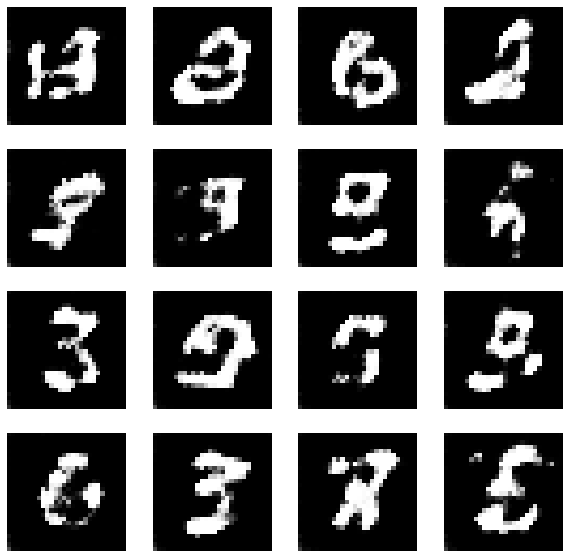

2500: [discriminator loss: 0.5801247358322144, acc: 0.2421875] [gan loss: 1.661974, acc: 0.000000]
2501: [discriminator loss: 0.5678980350494385, acc: 0.4609375] [gan loss: 0.969489, acc: 0.093750]
2502: [discriminator loss: 0.6234380006790161, acc: 0.203125] [gan loss: 1.482856, acc: 0.000000]
2503: [discriminator loss: 0.5670226216316223, acc: 0.46875] [gan loss: 1.299392, acc: 0.000000]
2504: [discriminator loss: 0.5922294855117798, acc: 0.3671875] [gan loss: 1.386453, acc: 0.015625]
2505: [discriminator loss: 0.583215594291687, acc: 0.359375] [gan loss: 1.471699, acc: 0.000000]
2506: [discriminator loss: 0.590178906917572, acc: 0.4375] [gan loss: 1.205977, acc: 0.015625]
2507: [discriminator loss: 0.5876519680023193, acc: 0.34375] [gan loss: 1.440279, acc: 0.000000]
2508: [discriminator loss: 0.5829926133155823, acc: 0.4140625] [gan loss: 1.033936, acc: 0.125000]
2509: [discriminator loss: 0.6246169805526733, acc: 0.234375] [gan loss: 1.704981, acc: 0.000000]
2510: [discriminator l

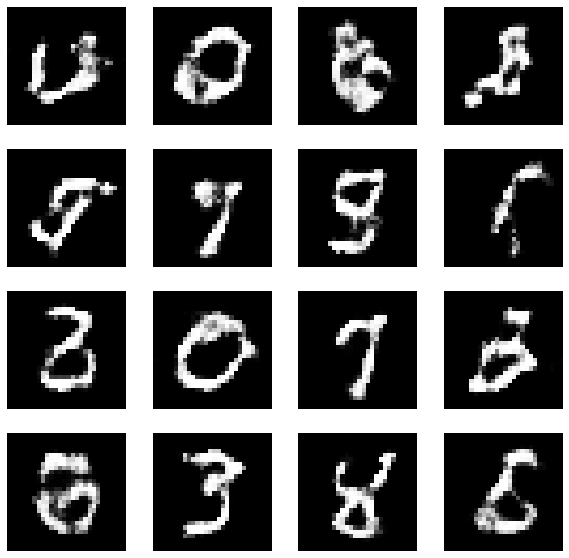

3000: [discriminator loss: 0.6430150270462036, acc: 0.3125] [gan loss: 1.365736, acc: 0.015625]
3001: [discriminator loss: 0.6442784667015076, acc: 0.3203125] [gan loss: 1.379258, acc: 0.015625]
3002: [discriminator loss: 0.625117838382721, acc: 0.3515625] [gan loss: 1.277740, acc: 0.015625]
3003: [discriminator loss: 0.6093671917915344, acc: 0.375] [gan loss: 1.214195, acc: 0.031250]
3004: [discriminator loss: 0.6276209354400635, acc: 0.34375] [gan loss: 1.414490, acc: 0.000000]
3005: [discriminator loss: 0.605641782283783, acc: 0.390625] [gan loss: 1.236040, acc: 0.031250]
3006: [discriminator loss: 0.6045078635215759, acc: 0.296875] [gan loss: 1.506987, acc: 0.015625]
3007: [discriminator loss: 0.6277526617050171, acc: 0.4453125] [gan loss: 0.929052, acc: 0.171875]
3008: [discriminator loss: 0.6897645592689514, acc: 0.1015625] [gan loss: 1.982646, acc: 0.000000]
3009: [discriminator loss: 0.6711046099662781, acc: 0.484375] [gan loss: 0.606609, acc: 0.687500]
3010: [discriminator los

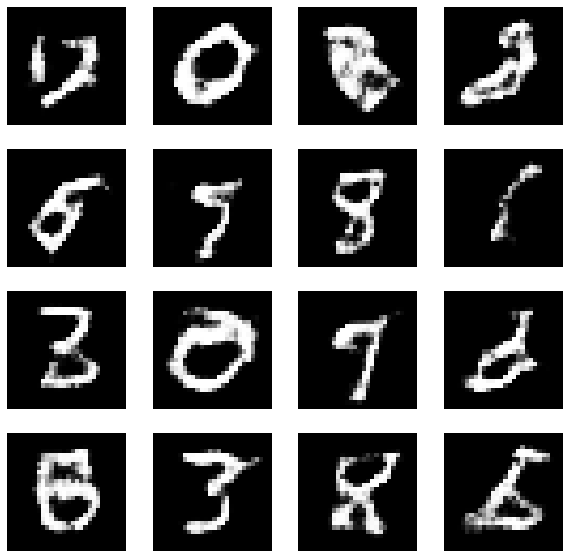

3500: [discriminator loss: 0.6451181173324585, acc: 0.28125] [gan loss: 1.289328, acc: 0.000000]
3501: [discriminator loss: 0.6268255710601807, acc: 0.296875] [gan loss: 1.519427, acc: 0.000000]
3502: [discriminator loss: 0.6461215019226074, acc: 0.3671875] [gan loss: 1.125192, acc: 0.109375]
3503: [discriminator loss: 0.6479521989822388, acc: 0.25] [gan loss: 1.510633, acc: 0.015625]
3504: [discriminator loss: 0.6111022233963013, acc: 0.453125] [gan loss: 0.849397, acc: 0.296875]
3505: [discriminator loss: 0.7369681596755981, acc: 0.1171875] [gan loss: 2.130880, acc: 0.000000]
3506: [discriminator loss: 0.6752094626426697, acc: 0.4921875] [gan loss: 0.609050, acc: 0.703125]
3507: [discriminator loss: 0.8486014008522034, acc: 0.0] [gan loss: 1.891546, acc: 0.000000]
3508: [discriminator loss: 0.6408402323722839, acc: 0.484375] [gan loss: 0.833233, acc: 0.281250]
3509: [discriminator loss: 0.7158929109573364, acc: 0.0859375] [gan loss: 1.854084, acc: 0.000000]
3510: [discriminator loss:

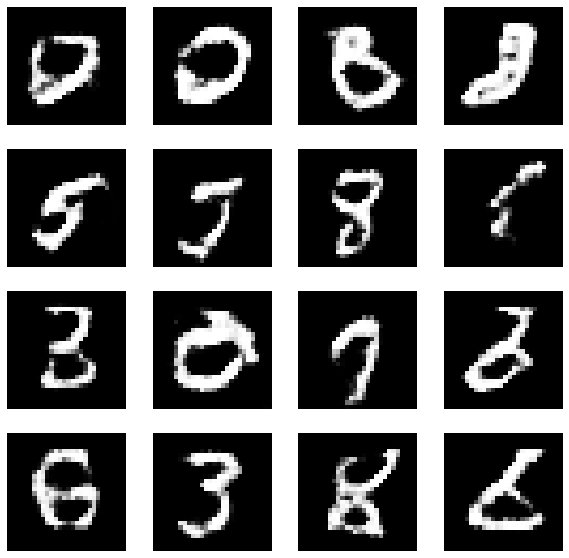

4000: [discriminator loss: 0.6198815107345581, acc: 0.4765625] [gan loss: 0.804599, acc: 0.421875]
4001: [discriminator loss: 0.6729018688201904, acc: 0.125] [gan loss: 1.710731, acc: 0.000000]
4002: [discriminator loss: 0.611988365650177, acc: 0.4296875] [gan loss: 0.884606, acc: 0.281250]
4003: [discriminator loss: 0.7145911455154419, acc: 0.1015625] [gan loss: 1.630308, acc: 0.000000]
4004: [discriminator loss: 0.6376556158065796, acc: 0.4609375] [gan loss: 0.981794, acc: 0.187500]
4005: [discriminator loss: 0.7035498023033142, acc: 0.125] [gan loss: 1.617265, acc: 0.000000]
4006: [discriminator loss: 0.6452739834785461, acc: 0.4453125] [gan loss: 0.865730, acc: 0.234375]
4007: [discriminator loss: 0.6847935914993286, acc: 0.09375] [gan loss: 1.802569, acc: 0.015625]
4008: [discriminator loss: 0.6818904280662537, acc: 0.4609375] [gan loss: 0.774415, acc: 0.453125]
4009: [discriminator loss: 0.7521687150001526, acc: 0.0625] [gan loss: 1.770937, acc: 0.000000]
4010: [discriminator los

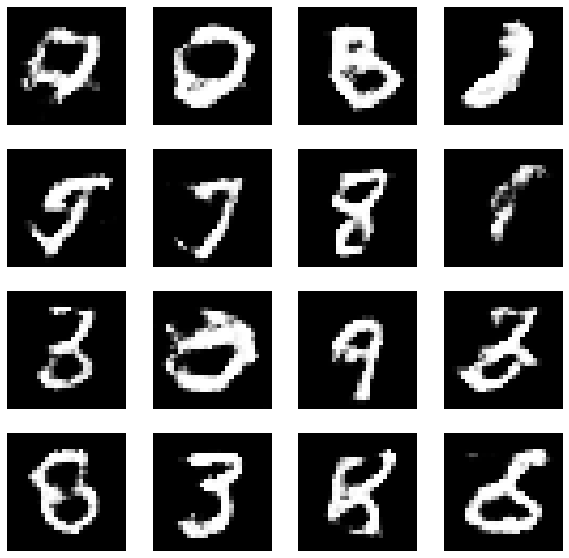

4500: [discriminator loss: 0.657129168510437, acc: 0.1875] [gan loss: 1.390857, acc: 0.000000]
4501: [discriminator loss: 0.6492931842803955, acc: 0.328125] [gan loss: 1.070754, acc: 0.046875]
4502: [discriminator loss: 0.7030918598175049, acc: 0.2109375] [gan loss: 1.355588, acc: 0.015625]
4503: [discriminator loss: 0.6460800766944885, acc: 0.34375] [gan loss: 1.043229, acc: 0.109375]
4504: [discriminator loss: 0.667250394821167, acc: 0.1875] [gan loss: 1.601878, acc: 0.000000]
4505: [discriminator loss: 0.6154779195785522, acc: 0.4453125] [gan loss: 0.775227, acc: 0.375000]
4506: [discriminator loss: 0.7013792991638184, acc: 0.1328125] [gan loss: 1.618836, acc: 0.000000]
4507: [discriminator loss: 0.6713918447494507, acc: 0.421875] [gan loss: 0.824740, acc: 0.359375]
4508: [discriminator loss: 0.7656893134117126, acc: 0.109375] [gan loss: 1.820812, acc: 0.000000]
4509: [discriminator loss: 0.6889396905899048, acc: 0.46875] [gan loss: 0.724961, acc: 0.484375]
4510: [discriminator loss

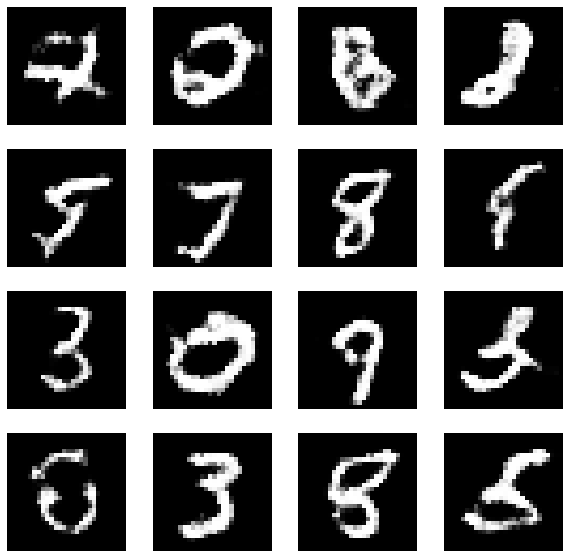

5000: [discriminator loss: 0.7283541560173035, acc: 0.0859375] [gan loss: 1.719476, acc: 0.000000]
5001: [discriminator loss: 0.6407639384269714, acc: 0.453125] [gan loss: 0.702372, acc: 0.484375]
5002: [discriminator loss: 0.778745174407959, acc: 0.015625] [gan loss: 1.782570, acc: 0.000000]
5003: [discriminator loss: 0.6738384366035461, acc: 0.4921875] [gan loss: 0.734407, acc: 0.468750]
5004: [discriminator loss: 0.7364515066146851, acc: 0.0234375] [gan loss: 1.736596, acc: 0.000000]
5005: [discriminator loss: 0.6503865122795105, acc: 0.4375] [gan loss: 0.824330, acc: 0.312500]
5006: [discriminator loss: 0.7150939702987671, acc: 0.078125] [gan loss: 1.684381, acc: 0.000000]
5007: [discriminator loss: 0.6860384941101074, acc: 0.3515625] [gan loss: 0.938082, acc: 0.140625]
5008: [discriminator loss: 0.7033729553222656, acc: 0.0703125] [gan loss: 1.620145, acc: 0.000000]
5009: [discriminator loss: 0.6201589703559875, acc: 0.5] [gan loss: 0.835419, acc: 0.218750]
5010: [discriminator lo

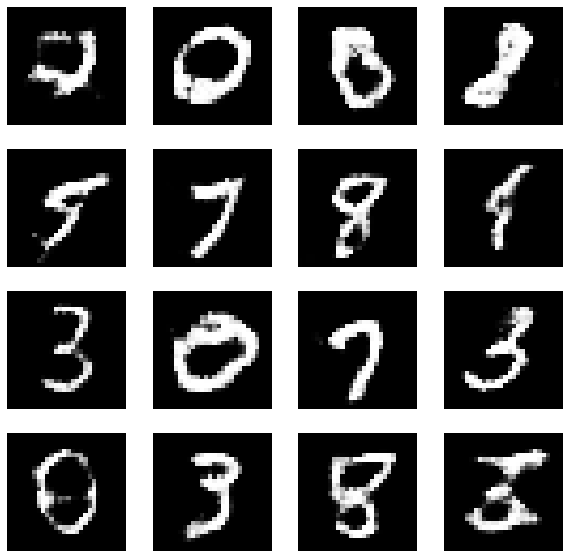

5500: [discriminator loss: 0.6784108877182007, acc: 0.3046875] [gan loss: 1.052749, acc: 0.093750]
5501: [discriminator loss: 0.6913833022117615, acc: 0.1640625] [gan loss: 1.525216, acc: 0.000000]
5502: [discriminator loss: 0.6633216738700867, acc: 0.375] [gan loss: 0.869750, acc: 0.187500]
5503: [discriminator loss: 0.7392345070838928, acc: 0.0625] [gan loss: 1.677665, acc: 0.000000]
5504: [discriminator loss: 0.6433102488517761, acc: 0.46875] [gan loss: 0.701035, acc: 0.546875]
5505: [discriminator loss: 0.8066738843917847, acc: 0.0078125] [gan loss: 2.089963, acc: 0.000000]
5506: [discriminator loss: 0.6839435696601868, acc: 0.5] [gan loss: 0.550511, acc: 0.828125]
5507: [discriminator loss: 0.8049265146255493, acc: 0.0234375] [gan loss: 1.747300, acc: 0.000000]
5508: [discriminator loss: 0.7042381763458252, acc: 0.4765625] [gan loss: 0.796752, acc: 0.328125]
5509: [discriminator loss: 0.7407562136650085, acc: 0.078125] [gan loss: 1.615873, acc: 0.000000]
5510: [discriminator loss:

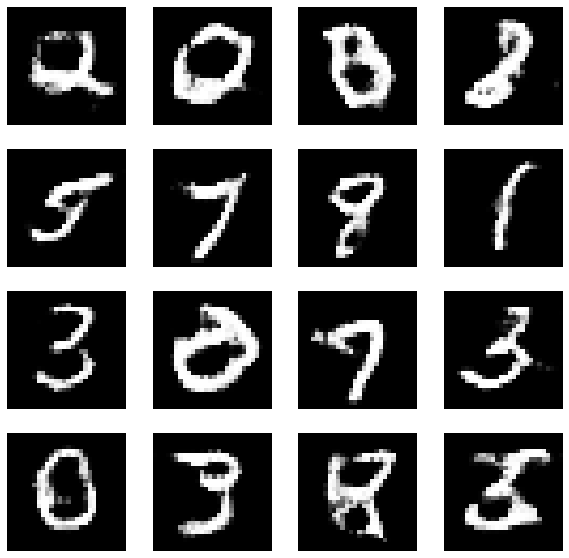

6000: [discriminator loss: 0.6845234632492065, acc: 0.3671875] [gan loss: 0.976411, acc: 0.140625]
6001: [discriminator loss: 0.700971245765686, acc: 0.109375] [gan loss: 1.434013, acc: 0.000000]
6002: [discriminator loss: 0.6822312474250793, acc: 0.3359375] [gan loss: 0.921173, acc: 0.156250]
6003: [discriminator loss: 0.7095932960510254, acc: 0.109375] [gan loss: 1.436819, acc: 0.000000]
6004: [discriminator loss: 0.6701407432556152, acc: 0.34375] [gan loss: 1.001444, acc: 0.125000]
6005: [discriminator loss: 0.6833071708679199, acc: 0.15625] [gan loss: 1.522094, acc: 0.000000]
6006: [discriminator loss: 0.6641517877578735, acc: 0.421875] [gan loss: 0.768671, acc: 0.359375]
6007: [discriminator loss: 0.7841814756393433, acc: 0.046875] [gan loss: 1.982322, acc: 0.000000]
6008: [discriminator loss: 0.7109779119491577, acc: 0.484375] [gan loss: 0.517506, acc: 0.859375]
6009: [discriminator loss: 0.8449737429618835, acc: 0.0078125] [gan loss: 1.784088, acc: 0.000000]
6010: [discriminator

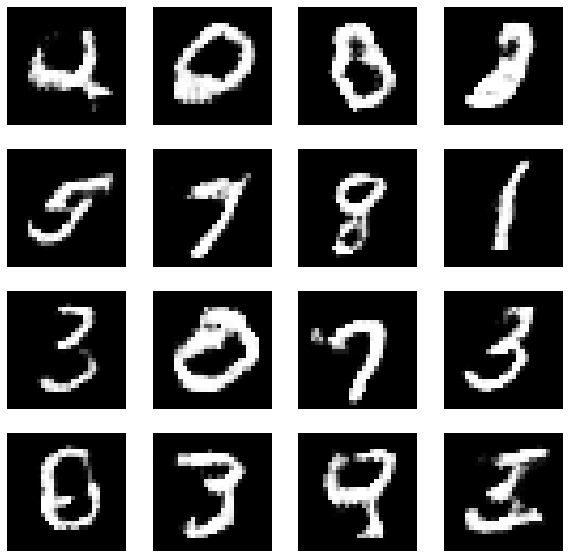

6500: [discriminator loss: 0.6631754636764526, acc: 0.390625] [gan loss: 0.924964, acc: 0.140625]
6501: [discriminator loss: 0.7313941121101379, acc: 0.078125] [gan loss: 1.388981, acc: 0.000000]
6502: [discriminator loss: 0.690470278263092, acc: 0.390625] [gan loss: 0.954747, acc: 0.078125]
6503: [discriminator loss: 0.6941646337509155, acc: 0.1640625] [gan loss: 1.457036, acc: 0.031250]
6504: [discriminator loss: 0.7080556154251099, acc: 0.296875] [gan loss: 0.932403, acc: 0.156250]
6505: [discriminator loss: 0.7059544324874878, acc: 0.140625] [gan loss: 1.361231, acc: 0.015625]
6506: [discriminator loss: 0.7063052654266357, acc: 0.3828125] [gan loss: 0.794111, acc: 0.265625]
6507: [discriminator loss: 0.7471217513084412, acc: 0.0703125] [gan loss: 1.627130, acc: 0.000000]
6508: [discriminator loss: 0.6930875778198242, acc: 0.4140625] [gan loss: 0.656324, acc: 0.593750]
6509: [discriminator loss: 0.7904318571090698, acc: 0.0078125] [gan loss: 1.783141, acc: 0.000000]
6510: [discrimin

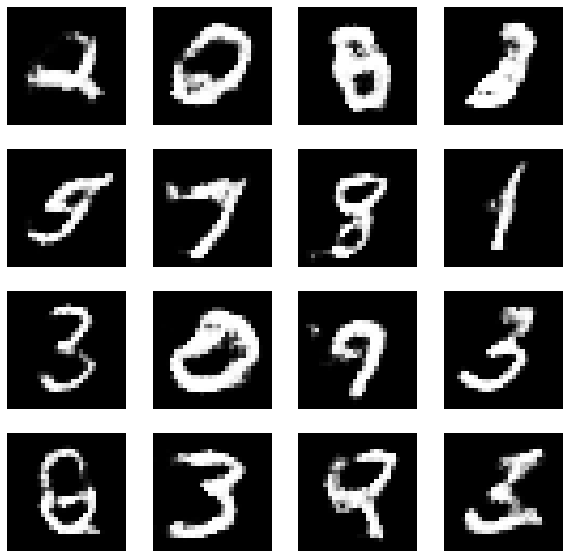

7000: [discriminator loss: 0.6737174987792969, acc: 0.390625] [gan loss: 0.859915, acc: 0.218750]
7001: [discriminator loss: 0.751034140586853, acc: 0.0546875] [gan loss: 1.638504, acc: 0.000000]
7002: [discriminator loss: 0.6853212118148804, acc: 0.4765625] [gan loss: 0.639280, acc: 0.687500]
7003: [discriminator loss: 0.7931267023086548, acc: 0.0] [gan loss: 1.676692, acc: 0.000000]
7004: [discriminator loss: 0.724615752696991, acc: 0.4375] [gan loss: 0.587533, acc: 0.765625]
7005: [discriminator loss: 0.7842437624931335, acc: 0.0390625] [gan loss: 1.504017, acc: 0.000000]
7006: [discriminator loss: 0.7037351727485657, acc: 0.421875] [gan loss: 0.765385, acc: 0.437500]
7007: [discriminator loss: 0.7712810635566711, acc: 0.0390625] [gan loss: 1.277498, acc: 0.015625]
7008: [discriminator loss: 0.7299380302429199, acc: 0.375] [gan loss: 0.841131, acc: 0.187500]
7009: [discriminator loss: 0.7577559947967529, acc: 0.0390625] [gan loss: 1.403839, acc: 0.000000]
7010: [discriminator loss: 

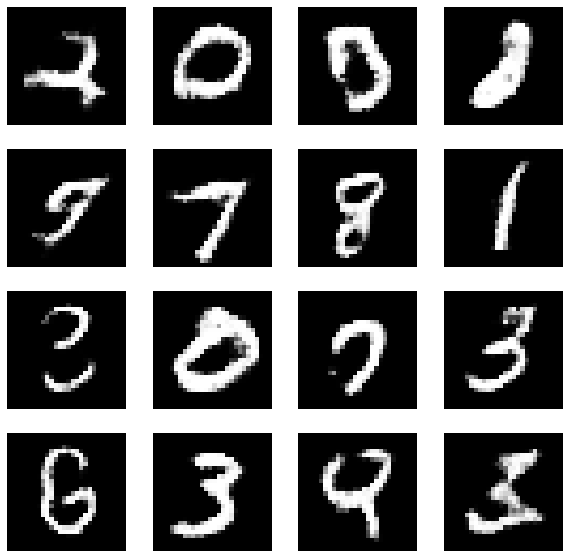

7500: [discriminator loss: 0.7073647975921631, acc: 0.3125] [gan loss: 0.969413, acc: 0.093750]
7501: [discriminator loss: 0.7524145841598511, acc: 0.09375] [gan loss: 1.451369, acc: 0.000000]
7502: [discriminator loss: 0.677486002445221, acc: 0.421875] [gan loss: 0.802337, acc: 0.265625]
7503: [discriminator loss: 0.7610841989517212, acc: 0.015625] [gan loss: 1.477080, acc: 0.000000]
7504: [discriminator loss: 0.7003047466278076, acc: 0.453125] [gan loss: 0.662753, acc: 0.625000]
7505: [discriminator loss: 0.8086111545562744, acc: 0.0] [gan loss: 1.716491, acc: 0.000000]
7506: [discriminator loss: 0.67244952917099, acc: 0.5] [gan loss: 0.548031, acc: 0.781250]
7507: [discriminator loss: 0.815220832824707, acc: 0.0390625] [gan loss: 1.618231, acc: 0.000000]
7508: [discriminator loss: 0.6971756219863892, acc: 0.4921875] [gan loss: 0.730766, acc: 0.406250]
7509: [discriminator loss: 0.8237055540084839, acc: 0.0078125] [gan loss: 1.532673, acc: 0.000000]
7510: [discriminator loss: 0.67524

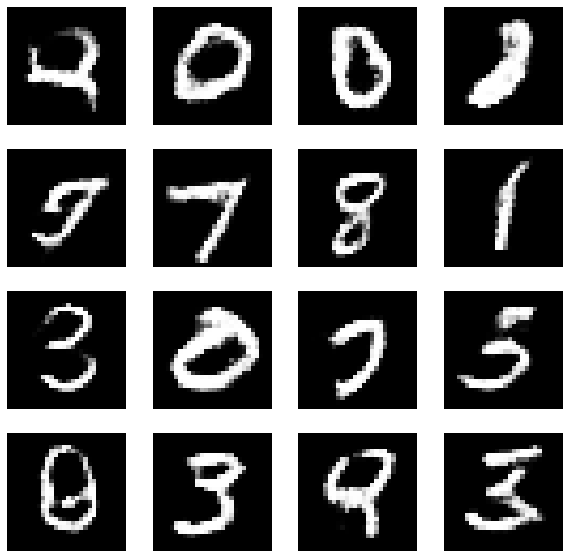

8000: [discriminator loss: 0.7050265073776245, acc: 0.453125] [gan loss: 0.680450, acc: 0.593750]
8001: [discriminator loss: 0.8042909502983093, acc: 0.0234375] [gan loss: 1.605113, acc: 0.000000]
8002: [discriminator loss: 0.7167547941207886, acc: 0.4140625] [gan loss: 0.681381, acc: 0.468750]
8003: [discriminator loss: 0.7863041162490845, acc: 0.0078125] [gan loss: 1.532173, acc: 0.000000]
8004: [discriminator loss: 0.7155612707138062, acc: 0.4375] [gan loss: 0.805398, acc: 0.218750]
8005: [discriminator loss: 0.7380611896514893, acc: 0.0546875] [gan loss: 1.404602, acc: 0.000000]
8006: [discriminator loss: 0.6967679262161255, acc: 0.3671875] [gan loss: 0.837027, acc: 0.203125]
8007: [discriminator loss: 0.7651946544647217, acc: 0.0546875] [gan loss: 1.397375, acc: 0.000000]
8008: [discriminator loss: 0.6897104382514954, acc: 0.4453125] [gan loss: 0.812395, acc: 0.218750]
8009: [discriminator loss: 0.7508217096328735, acc: 0.03125] [gan loss: 1.512832, acc: 0.000000]
8010: [discrimin

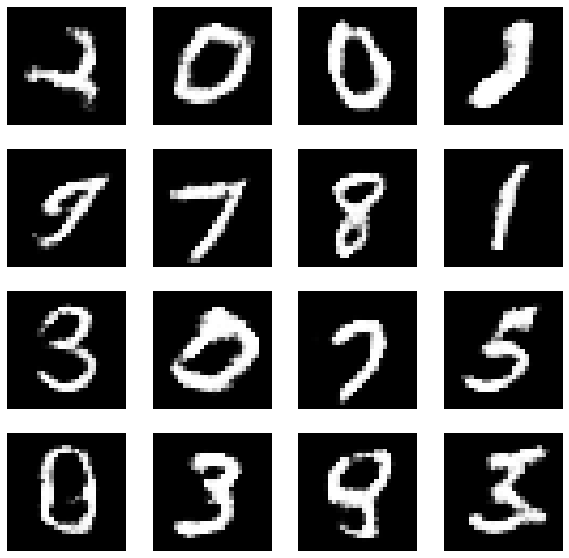

8500: [discriminator loss: 0.7324008345603943, acc: 0.078125] [gan loss: 1.333454, acc: 0.000000]
8501: [discriminator loss: 0.6844260096549988, acc: 0.40625] [gan loss: 0.879660, acc: 0.171875]
8502: [discriminator loss: 0.7354347705841064, acc: 0.1171875] [gan loss: 1.186435, acc: 0.046875]
8503: [discriminator loss: 0.7014634013175964, acc: 0.3203125] [gan loss: 0.856726, acc: 0.218750]
8504: [discriminator loss: 0.7493562698364258, acc: 0.078125] [gan loss: 1.317387, acc: 0.000000]
8505: [discriminator loss: 0.6873564720153809, acc: 0.390625] [gan loss: 0.859358, acc: 0.281250]
8506: [discriminator loss: 0.758186936378479, acc: 0.0859375] [gan loss: 1.395214, acc: 0.000000]
8507: [discriminator loss: 0.7251521944999695, acc: 0.375] [gan loss: 0.850920, acc: 0.171875]
8508: [discriminator loss: 0.7427476644515991, acc: 0.1015625] [gan loss: 1.379878, acc: 0.000000]
8509: [discriminator loss: 0.711654007434845, acc: 0.4296875] [gan loss: 0.726443, acc: 0.437500]
8510: [discriminator 

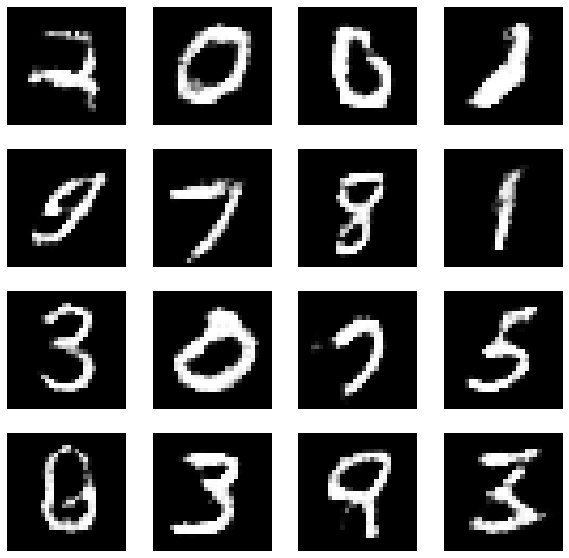

9000: [discriminator loss: 0.7398337125778198, acc: 0.0703125] [gan loss: 1.399339, acc: 0.000000]
9001: [discriminator loss: 0.7032761573791504, acc: 0.46875] [gan loss: 0.677649, acc: 0.578125]
9002: [discriminator loss: 0.7615727186203003, acc: 0.046875] [gan loss: 1.527238, acc: 0.000000]
9003: [discriminator loss: 0.7011587619781494, acc: 0.46875] [gan loss: 0.749304, acc: 0.406250]
9004: [discriminator loss: 0.7452541589736938, acc: 0.078125] [gan loss: 1.337450, acc: 0.000000]
9005: [discriminator loss: 0.6898606419563293, acc: 0.4765625] [gan loss: 0.769423, acc: 0.359375]
9006: [discriminator loss: 0.7553642988204956, acc: 0.03125] [gan loss: 1.280792, acc: 0.000000]
9007: [discriminator loss: 0.7055975198745728, acc: 0.4140625] [gan loss: 0.851735, acc: 0.156250]
9008: [discriminator loss: 0.7502273917198181, acc: 0.046875] [gan loss: 1.179370, acc: 0.000000]
9009: [discriminator loss: 0.7078235745429993, acc: 0.3671875] [gan loss: 0.900315, acc: 0.062500]
9010: [discriminato

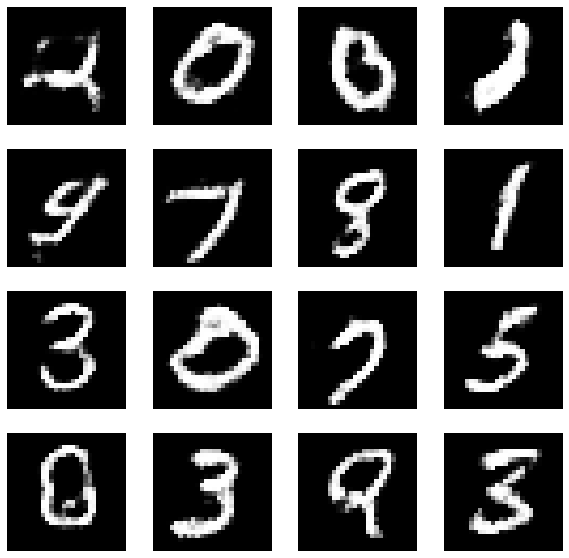

9500: [discriminator loss: 0.7105836868286133, acc: 0.140625] [gan loss: 1.244293, acc: 0.000000]
9501: [discriminator loss: 0.7213767766952515, acc: 0.296875] [gan loss: 0.912284, acc: 0.062500]
9502: [discriminator loss: 0.7636008262634277, acc: 0.1640625] [gan loss: 1.207491, acc: 0.000000]
9503: [discriminator loss: 0.7262914776802063, acc: 0.3359375] [gan loss: 0.818296, acc: 0.187500]
9504: [discriminator loss: 0.7135128974914551, acc: 0.1015625] [gan loss: 1.318785, acc: 0.000000]
9505: [discriminator loss: 0.6925432085990906, acc: 0.3828125] [gan loss: 0.825710, acc: 0.250000]
9506: [discriminator loss: 0.7310873866081238, acc: 0.046875] [gan loss: 1.276204, acc: 0.015625]
9507: [discriminator loss: 0.6909899711608887, acc: 0.4453125] [gan loss: 0.711325, acc: 0.500000]
9508: [discriminator loss: 0.7373387217521667, acc: 0.078125] [gan loss: 1.368063, acc: 0.000000]
9509: [discriminator loss: 0.7299646139144897, acc: 0.453125] [gan loss: 0.651765, acc: 0.640625]
9510: [discrimi

In [ ]:
train(models=[gen, disc, gan], x_train=x_train)

In [65]:
for layer in gen.layers:
    print(layer.name)
    try:
        df = pd.DataFrame(layer.get_weights()[0].T.reshape(-1, 128))
        
        display(df.describe())
    except:
        pass

dense_7


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
count,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,...,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4900.000000,4.900000e+03,4900.000000
mean,0.000069,0.000102,-0.000246,-0.000389,0.000130,-0.000427,0.000075,-0.000246,0.000095,-0.000308,0.000098,0.000124,-0.000031,-0.000307,0.000160,0.000224,0.000137,0.000248,0.000167,0.000164,0.000365,-0.000042,0.000035,0.000530,0.000017,-0.000171,-0.000195,-0.000005,-0.000347,-0.000040,0.000150,-0.000087,0.000447,-0.000047,-0.000072,-0.000325,0.000050,0.000103,-0.000239,-0.000060,...,0.000005,0.000136,0.000246,-0.000185,-0.000143,-0.000050,0.000155,-0.000010,-0.000276,-0.000246,0.000159,0.000037,-0.000016,-0.000414,-0.000267,0.000226,0.000011,-0.000030,0.000029,-0.000020,-0.000192,-0.000091,0.000159,0.000256,0.000102,-0.000019,-0.000068,-0.000023,0.000121,0.000003,0.000086,-0.000087,-0.000227,-0.000086,0.000022,0.000013,-0.000096,-0.000401,5.957027e-07,0.000179
std,0.016103,0.016009,0.015963,0.015942,0.016070,0.015848,0.016133,0.015997,0.015982,0.016010,0.015915,0.015976,0.015867,0.015906,0.016069,0.015895,0.015754,0.016090,0.015861,0.015635,0.016014,0.016186,0.016256,0.015888,0.016053,0.015836,0.016187,0.016245,0.016028,0.016017,0.015599,0.016088,0.015823,0.016281,0.016000,0.016114,0.015783,0.016103,0.015993,0.015704,...,0.016103,0.015952,0.015696,0.015794,0.016017,0.016024,0.016027,0.015958,0.015827,0.015963,0.015971,0.015902,0.016034,0.015729,0.015756,0.015937,0.016023,0.015916,0.015939,0.015761,0.015652,0.016129,0.016256,0.015850,0.015763,0.015920,0.015829,0.016016,0.015624,0.015596,0.016050,0.015852,0.016081,0.015815,0.015893,0.015696,0.015682,0.015978,1.586747e-02,0.016013
min,-0.050662,-0.056566,-0.047858,-0.052223,-0.051778,-0.049979,-0.048961,-0.049009,-0.053986,-0.049038,-0.055496,-0.055069,-0.052850,-0.051343,-0.050135,-0.049535,-0.048424,-0.052492,-0.053316,-0.051398,-0.051718,-0.052692,-0.051074,-0.051689,-0.053868,-0.053013,-0.052125,-0.050060,-0.048467,-0.051554,-0.051730,-0.052605,-0.050294,-0.048793,-0.052176,-0.052783,-0.052998,-0.053946,-0.051080,-0.052839,...,-0.048751,-0.050488,-0.048256,-0.056001,-0.050027,-0.051208,-0.051011,-0.051318,-0.048296,-0.047597,-0.050714,-0.052033,-0.048447,-0.047155,-0.054002,-0.052449,-0.049919,-0.047899,-0.047154,-0.050602,-0.050574,-0.051119,-0.057837,-0.053811,-0.051000,-0.050327,-0.048186,-0.051915,-0.050349,-0.050998,-0.050761,-0.051319,-0.052571,-0.046300,-0.050310,-0.052049,-0.051891,-0.047145,-4.917764e-02,-0.050998
25%,-0.010461,-0.010124,-0.010366,-0.010858,-0.010045,-0.010739,-0.010444,-0.010700,-0.010209,-0.010758,-0.010406,-0.009950,-0.010523,-0.010389,-0.010437,-0.010209,-0.010135,-0.010365,-0.010017,-0.010207,-0.009853,-0.010496,-0.009985,-0.009658,-0.010540,-0.010195,-0.010942,-0.010514,-0.010765,-0.010575,-0.009829,-0.010032,-0.009983,-0.010650,-0.010426,-0.010877,-0.010118,-0.010484,-0.010700,-0.010233,...,-0.010436,-0.010443,-0.009862,-0.010661,-

reshape_4
conv_trans_block_14


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
count,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
mean,1.009667,1.011762,1.012202,0.999938,0.985055,1.007311,1.003887,1.006909,0.980367,0.990979,1.007995,1.008603,0.982435,0.99572,1.002329,0.992653,0.987569,1.010866,1.002767,0.978246,1.009169,1.009043,0.978408,0.988885,0.991227,1.003236,0.999237,1.008865,1.002729,1.003449,1.001694,0.990352,0.994587,0.982006,0.993089,0.996235,0.97917,0.994326,0.994341,0.992834,...,0.98772,0.998055,1.005141,1.008542,0.992476,1.013149,0.994101,1.000908,1.008154,0.997087,0.988208,1.00025,1.007042,0.986021,1.00124,0.999967,1.010749,0.989907,0.993326,0.993137,1.007583,1.012241,0.994379,0.996485,0.995146,0.995418,0.998302,0.992474,0.999278,0.98676,1.00208,0.970148,0.996148,1.002422,1.004608,1.005918,1.002921,1.004027,0.975106,1.005918
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.009667,1.011762,1.012202,0.999938,0.985055,1.007311,1.003887,1.006909,0.980367,0.990979,1.007995,1.008603,0.982435,0.99572,1.002329,0.992653,0.987569,1.010866,1.002767,0.978246,1.009169,1.009043,0.978408,0.988885,0.991227,1.003236,0.999237,1.008865,1.002729,1.003449,1.001694,0.990352,0.994587,0.982006,0.993089,0.996235,0.97917,0.994326,0.994341,0.992834,...,0.98772,0.998055,1.005141,1.008542,0.992476,1.013149,0.994101,1.000908,1.008154,0.997087,0.988208,1.00025,1.007042,0.986021,1.00124,0.999967,1.010749,0.989907,0.993326,0.993137,1.007583,1.012241,0.994379,0.996485,0.995146,0.995418,0.998302,0.992474,0.999278,0.98676,1.00208,0.970148,0.996148,1.002422,1.004608,1.005918,1.002921,1.004027,0.975106,1.005918
25%,1.009667,1.011762,1.012202,0.999938,0.985055,1.007311,1.003887,1.006909,0.980367,0.990979,1.007995,1.008603,0.982435,0.99572,1.002329,0.992653,0.987569,1.010866,1.002767,0.978246,1.009169,1.009043,0.978408,0.988885,0.991227,1.003236,0.999237,1.008865,1.002729,1.003449,1.001694,0.990352,0.994587,0.982006,0.993089,0.996235,0.97917,0.994326,0.994341,0.992834,...,0.98772,0.998055,1.005141,1.008542,0.992476,1.013149,0.994101,1.000908,1.008154,0.997087,0.988208,1.00025,1.007042,0.986021,1.00124,0.999967,1.010749,0.989907,0.993326,0.993137,1.007583,1.012241,0.994379,0.996485,0.995146,0.995418,0.998302,0.992474,0.999278,0.98676,1.00208,0.970148,0.996148,1.002422,1.004608,1.005918,1.002921,1.004027,0.975106,1.005918
50%,1.009667,1.011762,1.012202,0.999938,0.985055,1.007311,1.003887,1.006909,0.980367,0.990979,1.007995,1.008603,0.982435,0.99572,1.002329,0.992653,0.987569,1.010866,1.002767,0.978246,1.009169,1.009043,0.978408,0.988885,0.991227,1.003236,0.999237,1.008865,1.002729,1.003449,1.001694,0.990352,0.994587,0.982006,0.993089,0.996235,0.97917,0.994326,0.994341,0.992834,...,0.98772,0.998055,1.005141,1.008542,0.992476,1.013149,0.994101,1.000908,1.008154,0.997087,0.988208,1.00025,1.007042,0.986021,1.00124,0.999967,1.010749,0.9899

conv_trans_block_15


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
count,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,1.000000
mean,0.993737,0.99683,1.002031,1.013713,1.006133,1.001171,1.009853,1.001342,1.008162,1.00205,0.993886,1.000062,0.997335,0.987785,1.00197,0.995764,0.991636,0.994293,0.996284,0.996068,0.993233,1.003574,0.99276,1.003377,0.990974,1.000663,0.994784,0.991328,0.989916,0.999591,0.991639,0.996234,1.008404,1.003346,0.991031,0.999117,0.993729,0.995164,0.994916,0.995566,...,1.005608,0.989219,0.987627,0.999931,1.006638,1.00298,0.992956,0.998666,0.98926,0.99663,1.005869,1.003529,1.005053,0.994999,1.011835,1.001468,1.006677,0.998059,0.99398,1.001571,0.996599,0.993639,0.996694,1.006816,1.014685,0.989651,1.012758,1.00731,0.991233,1.019647,0.996789,1.003528,0.992621,0.992612,1.00195,0.996996,0.99308,0.990122,0.996108,0.996281
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.993737,0.99683,1.002031,1.013713,1.006133,1.001171,1.009853,1.001342,1.008162,1.00205,0.993886,1.000062,0.997335,0.987785,1.00197,0.995764,0.991636,0.994293,0.996284,0.996068,0.993233,1.003574,0.99276,1.003377,0.990974,1.000663,0.994784,0.991328,0.989916,0.999591,0.991639,0.996234,1.008404,1.003346,0.991031,0.999117,0.993729,0.995164,0.994916,0.995566,...,1.005608,0.989219,0.987627,0.999931,1.006638,1.00298,0.992956,0.998666,0.98926,0.99663,1.005869,1.003529,1.005053,0.994999,1.011835,1.001468,1.006677,0.998059,0.99398,1.001571,0.996599,0.993639,0.996694,1.006816,1.014685,0.989651,1.012758,1.00731,0.991233,1.019647,0.996789,1.003528,0.992621,0.992612,1.00195,0.996996,0.99308,0.990122,0.996108,0.996281
25%,0.993737,0.99683,1.002031,1.013713,1.006133,1.001171,1.009853,1.001342,1.008162,1.00205,0.993886,1.000062,0.997335,0.987785,1.00197,0.995764,0.991636,0.994293,0.996284,0.996068,0.993233,1.003574,0.99276,1.003377,0.990974,1.000663,0.994784,0.991328,0.989916,0.999591,0.991639,0.996234,1.008404,1.003346,0.991031,0.999117,0.993729,0.995164,0.994916,0.995566,...,1.005608,0.989219,0.987627,0.999931,1.006638,1.00298,0.992956,0.998666,0.98926,0.99663,1.005869,1.003529,1.005053,0.994999,1.011835,1.001468,1.006677,0.998059,0.99398,1.001571,0.996599,0.993639,0.996694,1.006816,1.014685,0.989651,1.012758,1.00731,0.991233,1.019647,0.996789,1.003528,0.992621,0.992612,1.00195,0.996996,0.99308,0.990122,0.996108,0.996281
50%,0.993737,0.99683,1.002031,1.013713,1.006133,1.001171,1.009853,1.001342,1.008162,1.00205,0.993886,1.000062,0.997335,0.987785,1.00197,0.995764,0.991636,0.994293,0.996284,0.996068,0.993233,1.003574,0.99276,1.003377,0.990974,1.000663,0.994784,0.991328,0.989916,0.999591,0.991639,0.996234,1.008404,1.003346,0.991031,0.999117,0.993729,0.995164,0.994916,0.995566,...,1.005608,0.989219,0.987627,0.999931,1.006638,1.00298,0.992956,0.998666,0.98926,0.99663,1.005869,1.003529,1.005053,0.994999,1.011835,1.001468,1.006677,0.998059,0.99398,1.00157

conv_trans_block_16
conv_trans_block_17
activation_21


In [46]:
for layer in gen.layers:
    print(layer.name)


dense_3
reshape_2
conv_trans_block_6
conv_trans_block_7
conv_trans_block_8
conv_trans_block_9
activation_11
